# Volt-var control
In this example, we investigate the effects on voltages if we can control reactive power injection in some of the buses. We adopt the single-phase Linear DistFlow model for simplicity. The purpose of this example is not to develop a sophisticated control algorithm, but rather show the example usage of our dataset and helper functions.

## Data preparation
Because we do not directly measure all of the 2.4kV nodes, we first run state estimation to get the un-measured voltages and currents. 

In [1]:
import os, sys
assert os.getcwd().endswith('digital-twin-dataset/code_examples'), os.getcwd()
sys.path.append(os.path.join(os.getcwd(), '../utils'))
from state_estimation_phasor import StateEstimator, get_timeseries
from global_param import FILE_PATHS, JOIN_CHAR

output_data_dir = 'temp/state_estimation_BIM'
measured_injections = {
    "bus_1014|bus_1015|bus_1016|bus_1017|bus_1019|bus_1020|bus_1027|bus_1029|bus_1030|bus_1031|bus_1032|bus_1033|bus_1037|bus_1038|bus_1053|bus_1199": 
        [{"element": "line_381", "sign": 1}],
    "bus_1118|bus_1119|bus_1120|bus_1127": 
        [{"element": "cb_146", "sign": -1}],
    "bus_1082|bus_1083|bus_1084": 
        [{"element": "cb_137", "sign": -1}],
    "bus_1097|bus_1098|bus_1099": 
        [{"element": "cb_140", "sign": -1}],
    "bus_1106|bus_1107|bus_1108": 
        [{"element": "cb_143", "sign": -1}],
    "bus_1069|bus_1070|bus_1071|bus_1078": 
        [{"element": "cb_134", "sign": -1}],
}
keep_cc = [0]
prune_nodes = ["bus_1130|bus_1142|bus_1144|bus_1146|bus_1147"]
prune_edges = []
datetimespan = ('2024-11-14T07:00:00', '2024-11-14T07:05:00')
state_estimator = StateEstimator(
    network_files=[os.path.join(FILE_PATHS['net_files'], 'circuit3')], 
    input_data_dir=FILE_PATHS['phasors'],
    output_data_dir=output_data_dir,
    phase_ref='bus_1038.ag',
    delta_t_threshold=1.0,
)
state_estimator.state_estimation(
    datetimespan, 
    print_info=False,
    keep_cc=keep_cc,
    prune_nodes=prune_nodes,
    prune_edges=prune_edges,
    measured_injections=measured_injections,
    algorithm='businjection_VI',
)
elements_to_plot = ['bus_1033', 'bus_1034', 'bus_1118', 'bus_1082', 'bus_1097', 'bus_1106', 'bus_1069']
elements_to_plot += ['bus_1014|bus_1015|bus_1016|bus_1017|bus_1019|bus_1020|bus_1027|bus_1029|bus_1030|bus_1031|bus_1032|bus_1033|bus_1037|bus_1038|bus_1053|bus_1199-I', 'bus_1118|bus_1119|bus_1120|bus_1127-I', 'bus_1082|bus_1083|bus_1084-I', 'bus_1097|bus_1098|bus_1099-I', 'bus_1106|bus_1107|bus_1108-I', 'bus_1069|bus_1070|bus_1071|bus_1078-I']
outdir = 'temp/state_estimation_plots/results_BIM'
from state_estimation_phasor import plot_results
plot_results(output_data_dir, datetimespan, '2024-11-13T23:30:42.000000.json', elements_to_plot, outdir=outdir, ext='png', combine_3_phase=True, show=False)


Distinct topologies starting at the following timestamps: ['2024-11-13T23:30:42.000000']
[Warning] Unknown phase configuration: ['ab'] for bus_1041


100%|██████████| 25/25 [00:00<00:00, 110.98it/s]


## Load circuit topology and parameters
First, prune electrical network.

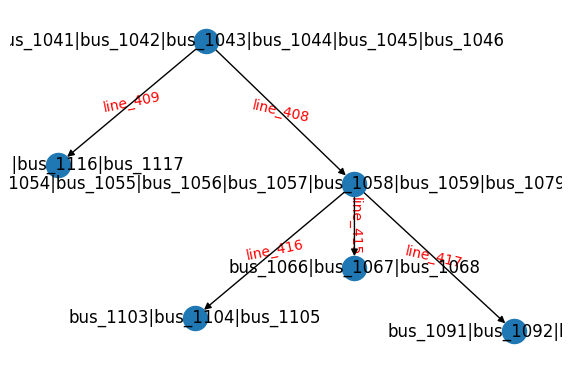

In [2]:
import utils
import topology
import networkx as nx

net_files = [os.path.join(FILE_PATHS['net_files'], 'circuit3')]

# Initialize element inheritance lookup dictionary
element_inheritance = utils.load_json(FILE_PATHS["element_inheritance"])
element_parents = utils.dict_parents(element_inheritance)
# Load network files & generate graph
net_data = topology.load_net_files(net_files, t=datetimespan[0])
nodes_c, edges_c, decorators_c = topology.net2graph(net_data, element_parents)
nodes_e, edges_e, decorators_e = \
    topology.graph2electrical_graph(nodes_c, edges_c, {}, net_data, element_parents)
edge_info = topology.to_edge_dict(edges_e, flip=False)  # edge node -> node tuple
G = nx.DiGraph(topology.to_edge_list(edges_e))
if keep_cc:
    cc = nx.weakly_connected_components(G)
    keep_nodes = utils.flatten_iterable([list(c) for i, c in enumerate(cc) if i in keep_cc], 2)
    G = G.subgraph(keep_nodes).copy()
    nodes_e = {k: v for k, v in nodes_e.items() if k in G.nodes}
    edges_e = {k: v for k, v in edges_e.items() if edge_info[k] in G.edges}
if prune_nodes:
    G.remove_nodes_from(prune_nodes)
    for node in prune_nodes:
        del nodes_e[node]
        to_delete = [e for e, el in edges_e.items() if node in (el['source'], el['target'])]
        for node in to_delete:
            del edges_e[node]
        to_delete = [edge_info[e] for e in to_delete]
        G.remove_edges_from(to_delete)
if prune_edges:
    G.remove_edges_from([edge_info[e] for e in prune_edges])
    for edge in prune_edges:
        del edges_e[edge]
# Remove all transformers
edge_dict = topology.to_edge_dict(edges_e, flip=True)   # node tuple -> edge node
all_transformers = [e for e in G.edges if edges_e[edge_dict[e]]['element_type'] == 'Transformer']
G.remove_edges_from(all_transformers)
G.remove_nodes_from(list(nx.isolates(G)))
# Update graph information
nodelist = list(nx.topological_sort(G))
edgelist = [edge_dict[e] for e in G.edges]
nodes = {k: nodes_e[k] for k in nodelist}
edges = {v: edges_e[v] for v in edge_dict.values() if v in edgelist}
# Plot the pruned final graph
topology.plot_nx_graph(G, edge_info=edge_dict, figsize=(6, 4))
    

Build R, X matrices.

In [3]:
import numpy as np

R_matrix, X_matrix, C_matrix = None, None, None
assert nx.is_tree(G), "The network is not a tree."
assert len(G.nodes) == len(G.edges) + 1, (len(G.nodes), len(G.edges))
N = len(G.nodes) - 1
C_matrix = nx.incidence_matrix(G, oriented=True, nodelist=nodelist).toarray()
C_hat = C_matrix[1:, :]
C_inv = np.linalg.inv(C_hat)
resistances, reactances = np.zeros(N), np.zeros(N)
for i, edge_tuple in enumerate(G.edges):
    edge_name = edge_dict[edge_tuple]
    edge_element = topology.get_element(edges[edge_name], net_data)
    if "Line" in element_parents[edges[edge_name]['element_type']]:
        y, zero_impedance = topology.line_Y_matrix(edge_element, returned_matrix='series Z')
        resistances[i] = np.real(np.diag(y)[:3]).mean()
        reactances[i] = np.imag(np.diag(y)[:3]).mean()
    else:
        raise RuntimeError(f"Unsupported edge type: {edge_element['element_type']}.")
    if zero_impedance:
        raise RuntimeError(f"Zero impedance detected in edge: {edge_name}.")
R_matrix = C_inv.T @ np.diag(resistances) @ C_inv
X_matrix = C_inv.T @ np.diag(reactances) @ C_inv
print(R_matrix.shape, X_matrix.shape)

(5, 5) (5, 5)


Load timeseries voltage and current phasor.

In [10]:
df_cache, metadata_cache = {}, {}
s_inj, v_nodal, time_col = [], [], None
for node in nodelist:
    # Get voltage
    df_V = get_timeseries(node.split(JOIN_CHAR)[0], datetimespan, df_cache, metadata_cache, data_dir=output_data_dir)
    # Get current injection
    df_I = get_timeseries(node + '-I', datetimespan, df_cache, metadata_cache, data_dir=output_data_dir)
    print(df_I['a'], node)
    asd
    # Check time column is aligned
    assert (df_V['t'] == df_I['t']).all(), (df_V['t'], df_I['t'])
    if time_col is None:
        time_col = df_V['t']
    else:
        assert (time_col == df_V['t']).all(), (time_col, df_V['t'])
    # Stack and compute power injection
    V = np.stack([df_V['a'], df_V['b'], df_V['c']], axis=1)
    I = np.stack([df_I['a'], df_I['b'], df_I['c']], axis=1)
    s_inj.append(V * np.conjugate(I))
    print(np.abs(I).mean())
    print(np.abs(V).mean())
    v_nodal.append(V)
    
# Stack data matrices
v_nodal = np.abs(np.stack(v_nodal, axis=0)) ** 2
s_inj = np.stack(s_inj, axis=0)
p_inj, q_inj = np.real(s_inj), np.imag(s_inj)
# Single-phase conversion
p_inj, q_inj, v_nodal = p_inj.mean(axis=-1), q_inj.mean(axis=-1), v_nodal.mean(axis=-1)
print(p_inj.shape, q_inj.shape, v_nodal.shape)

[ -7906091.  +8504281.j   -8511762.  +8889119.j   -8782205.  +9012633.j   -9239976.  +9111997.j   -8487374.  +8397136.j   -8208431.5 +8409864.j   -9041697.  +8870126.j   -8695324.  +8520420.j   -8100704.5 +8389998.j   -8255853.5 +8194586.j
  -9500033.  +9488650.j   -9038771.  +9058786.j   -8342977.  +8753477.j   -9386318.  +9342984.j   -9128326.  +8819656.j   -8417465.  +8769468.j   -9134292.  +8999843.j   -9770796.  +9304883.j   -8117666.5 +8149414.5j  -8943404.  +8763627.j
  -9123691.  +8796429.j   -7556834.  +8302855.5j  -7789651.  +8124362.j  -11646763. +10412510.j   -9470468.  +9099111.j ] bus_1034|bus_1041|bus_1042|bus_1043|bus_1044|bus_1045|bus_1046


NameError: name 'asd' is not defined

In [5]:
def plot_lindistflow(time_col, v_nodal, p_inj, q_inj, nodelist, V_pu=1):
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    timefmt = mdates.DateFormatter('%M:%S')
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    v_labels = [node.split(JOIN_CHAR)[0] for node in nodelist]
    ax[0].plot(time_col, (v_nodal.transpose() ** 0.5) / V_pu, label=v_labels)
    ax[0].set_title('Bus Voltage')
    ax[0].set_xlabel('Time (minute:second)')
    ax[0].set_ylabel('Voltage (pu)')
    ax[0].legend(loc='upper right')
    ax[0].xaxis.set_major_formatter(timefmt)
    ax[1].plot(time_col, p_inj.transpose(), label=v_labels)
    ax[1].set_title('Real power injection')
    ax[1].set_xlabel('Time (minute:second)')
    ax[1].set_ylabel('Real Power (kW)')
    ax[1].legend(loc='upper right')
    ax[1].xaxis.set_major_formatter(timefmt)
    ax[2].plot(time_col, q_inj.transpose(), label=v_labels)
    ax[2].set_title('Reactive power injection')
    ax[2].set_xlabel('Time (minute:second)')
    ax[2].set_ylabel('Reactive Power (kVar)')
    ax[2].legend(loc='upper right')
    ax[2].xaxis.set_major_formatter(timefmt)
    plt.tight_layout()

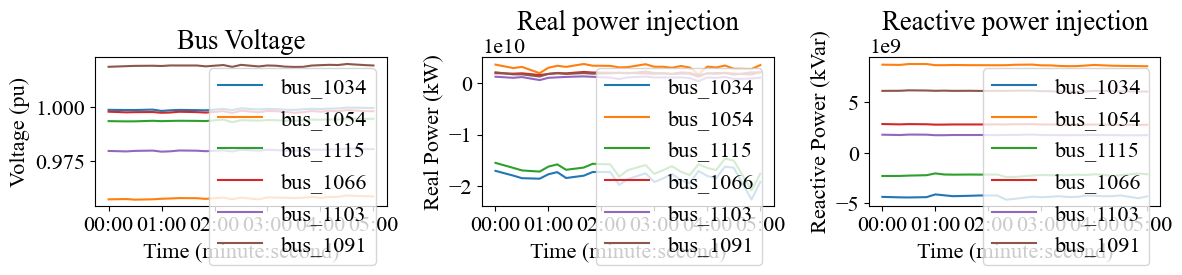

In [6]:
plot_lindistflow(time_col, v_nodal, p_inj, q_inj, nodelist, V_pu=2.4e3/3**0.5)

# Voltage control
Here we use a simple proportional controller based on previous timestamps.

(6, 25)
[ 2.71e+08 -4.65e+07  3.06e+08  2.87e+08  2.94e+08]
[ 4.82e+09 -4.26e+07  5.19e+09  5.02e+09  5.40e+09]
[1915307.5]
[ 2.87e+08 -4.79e+07  3.23e+08  3.06e+08  3.10e+08]
[ 4.87e+09 -4.20e+07  5.25e+09  5.08e+09  5.45e+09]
[1915270.]
[ 1.91e+08 -4.86e+07  2.21e+08  2.00e+08  2.09e+08]
[ 4.86e+09 -4.13e+07  5.23e+09  5.06e+09  5.44e+09]
[1915997.4]
[ 2.74e+08 -4.58e+07  3.08e+08  2.91e+08  2.99e+08]
[ 4.80e+09 -3.79e+07  5.17e+09  5.00e+09  5.38e+09]
[1913682.6]
[ 3.03e+08 -4.46e+07  3.40e+08  3.21e+08  3.30e+08]
[ 4.81e+09 -3.99e+07  5.18e+09  5.01e+09  5.39e+09]
[1914837.]
[ 2.91e+08 -4.76e+07  3.27e+08  3.10e+08  3.15e+08]
[ 4.82e+09 -4.02e+07  5.19e+09  5.02e+09  5.39e+09]
[1915478.4]
[ 3.32e+08 -4.64e+07  3.73e+08  3.53e+08  3.58e+08]
[ 4.81e+09 -4.00e+07  5.18e+09  5.01e+09  5.39e+09]
[1915079.9]
[ 3.08e+08 -4.43e+07  3.47e+08  3.28e+08  3.33e+08]
[ 4.81e+09 -4.02e+07  5.18e+09  5.01e+09  5.38e+09]
[1914685.6]
[ 3.02e+08 -4.46e+07  3.40e+08  3.19e+08  3.27e+08]
[ 4.81e+09 -4.

/tmp/ipykernel_437404/277150852.py:7: RuntimeWarning: invalid value encountered in sqrt
  ax[0].plot(time_col, (v_nodal.transpose() ** 0.5) / V_pu, label=v_labels)


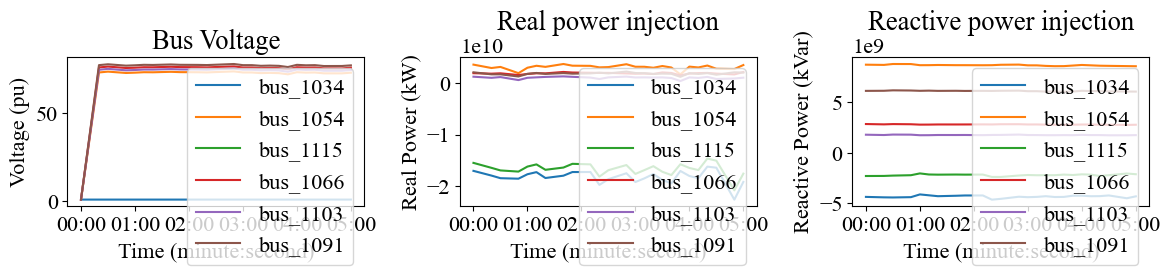

In [7]:
p_inj_ctrl = p_inj.copy()
q_inj_ctrl = q_inj.copy()
v_simulation = v_nodal.copy()
print(v_nodal.shape)
for t in range(1, len(time_col)):
    # Control law: proportional control based on previous timestep's voltage
    # q_inj_ctrl[1:, t] += (v_simulation[1:, t-1] - 1) * [-1e-4, -1e-4, -1e-4, -1e-4, -1e-4]
    v_simulation[1:, t] = v_nodal[:1, t] + 2 * (R_matrix @ p_inj_ctrl[1:, t] + X_matrix @ q_inj_ctrl[1:, t])
    print(R_matrix @ p_inj_ctrl[1:, t])
    print(X_matrix @ q_inj_ctrl[1:, t])
    print(v_nodal[:1, t])
plot_lindistflow(time_col, v_simulation, p_inj_ctrl, q_inj_ctrl, nodelist, V_pu=2.4e3/3**0.5)
